In [ ]:
# ! wget "https://osf.io/drjhb/download"

In [ ]:
import os
import json
import math
import librosa

import requests
import pickle

# Download Dataset

In [ ]:
ZIP_FILE = "music.zip"
if ZIP_FILE in os.listdir():
  print("Dataset file already exist")
else:
  print("Finding the link to web.....")
  try:
    request = requests.get('https://osf.io/drjhb/download')
  except requests.ConnectionError as err:
    print(f"Error: {err}")
  with open(ZIP_FILE, 'wb') as file:
    file.write(request.content)

In [ ]:
# unzip the dataset
from zipfile import ZipFile
with ZipFile(ZIP_FILE, "r") as zipObj:
  zipObj.extractall()

In [ ]:
os.listdir()

In [ ]:
DATASET_DIR = "/content/Data/genres_original"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # Track duration is 30 sec

# 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
print(f"Number of samples per track: {SAMPLES_PER_TRACK}")

Number of samples per track: 661500


In [ ]:
def extract_mfcc(SAMPLES_PER_TRACK, parts=5, num_mfcc=13, n_fft=2048, hop_length=512):

  data = {
      "mapping": [],
      "labels": [],
      "mfcc": [],
  }

  samples_per_segment = int(SAMPLES_PER_TRACK / parts)
  mfcc_per_segment = math.ceil(samples_per_segment / hop_length)

  # walk through all genres_original to get raw audio file
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_DIR)):
    # select only subfolder of genre
    # file inside DATASET_PATH/ main dir is not included
    if dirpath is not DATASET_DIR:

      # save dir file as label
      label = os.path.basename(dirpath)
      data["mapping"].append(label)
      print(f"Loading file from {label.upper()} genre....")

      # process all raw audio files
      for file in filenames:

        filepath = os.path.join(dirpath, file)
        # load the audio file
        try:
          y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
        except:
          continue

        for part in range(parts):

          # find the start and finish of segment
          start = samples_per_segment * part
          end = start + samples_per_segment

          # extract mfcc
          mfcc = librosa.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T

          if len(mfcc) == mfcc_per_segment:
            data["mfcc"].append(mfcc)
            data["labels"].append(i-1)
          else:
            print(f"[INFO] {part} segment of {file} is not included ")
  with open('data_feature.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return data

feature = extract_mfcc(SAMPLES_PER_TRACK=SAMPLES_PER_TRACK)

Loading file from HIPHOP genre....
[INFO] 4 segment of hiphop.00032.wav is not included 
Loading file from REGGAE genre....
Loading file from BLUES genre....
Loading file from COUNTRY genre....
[INFO] 4 segment of country.00007.wav is not included 
Loading file from DISCO genre....
Loading file from CLASSICAL genre....
Loading file from JAZZ genre....


<ipython-input-7-e4871a296e18>:29: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loading file from METAL genre....
Loading file from ROCK genre....
Loading file from POP genre....


In [ ]:
# Import the required libraries
from collections import Counter
import numpy as np

# Load feature mapping and labels into variables
labels_name = feature["mapping"]
labels = np.array(feature["labels"])

# Count the occurrences of each label
counter = Counter(labels)

# Print the count of each label
print(f"labels_name: {labels_name}")
counter

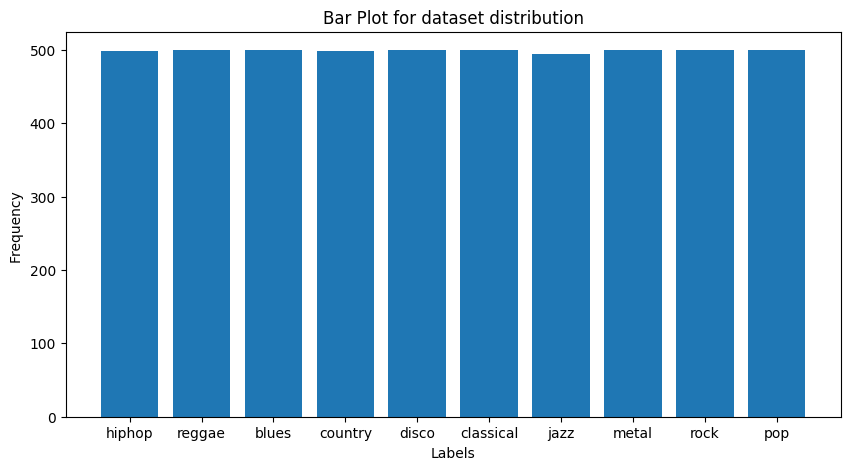

In [ ]:
# Import the necessary libraries
from matplotlib import pyplot as plt

# Set the figure size of the plot
plt.figure(figsize=(10, 5))

# Create a bar plot using the provided data
plt.bar(labels_name, height=counter.values())

# Set the title of the plot
plt.title("Bar Plot for dataset distribution")

# Label the x-axis
plt.xlabel("Labels")

# Label the y-axis
plt.ylabel("Frequency ")

# Display the plot
plt.show()

In [ ]:
# Convert the "mfcc" feature dictionary to a numpy array
mfcc = np.array(feature["mfcc"])

# Normalize the values of the "mfcc" array to be between 0 and 1
mfcc = mfcc / np.max(mfcc)

# Print the shape of the normalized "mfcc" array
print(f"Shape of mfcc: {mfcc.shape}")

Shape of mfcc: (4993, 259, 13)


Text(0.5, 1.0, 'MFCCs')

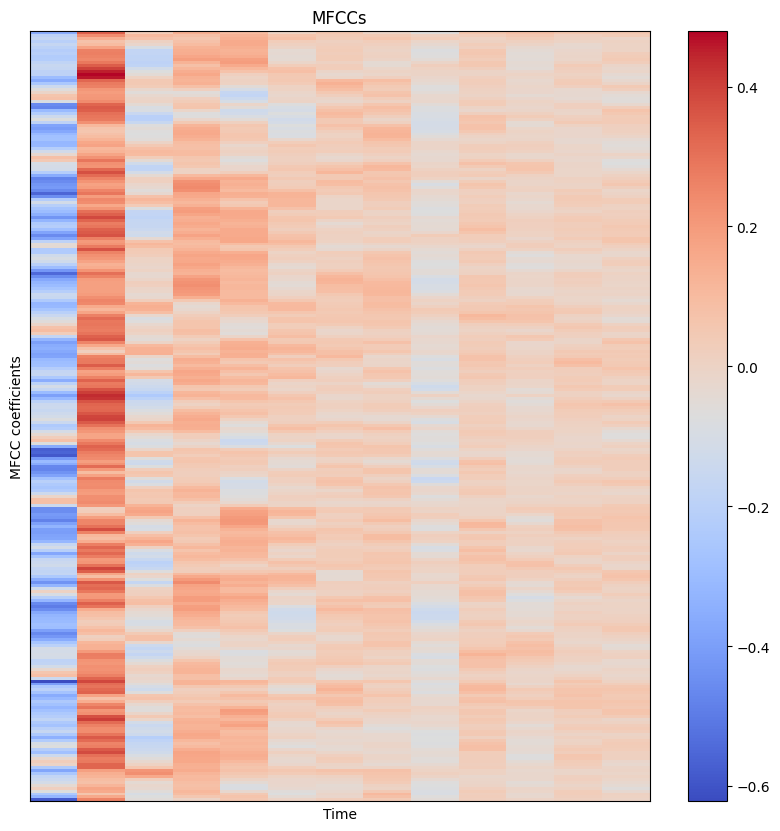

In [ ]:
# display MFCCs
plt.figure(figsize=(10, 10))
librosa.display.specshow(mfcc[0], sr=SAMPLE_RATE, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

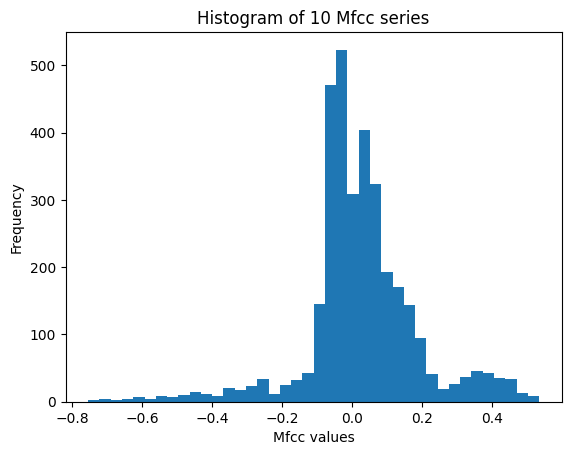

In [ ]:
# Select the 10th row of the "mfcc" array, which represents one series of MFCC coefficients
mfcc_series = mfcc[10, :]

# Reshape the selected series to a 1D array using the "view" method, then flatten it to remove any nested arrays
mfcc_series_flat = mfcc_series.view().reshape(-1)

# Create a histogram of the flattened "mfcc_series_flat" array with 40 bins
plt.hist(mfcc_series_flat, bins=40)

# Set the title of the plot
plt.title("Histogram of 10th MFCC series")

# Label the y-axis
plt.ylabel("Frequency")

# Label the x-axis
plt.xlabel("MFCC values")

# Display the plot
plt.show()

In [ ]:
# Import the necessary library for splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Split the "mfcc" and "labels" arrays into training and testing sets with a test size of 20% and a random state of 42
X_train, X_test, y_train, y_test = train_test_split(mfcc, labels, test_size=0.2, random_state=42)

# Print the shape of the "X_train" array
print(f"Shape of X_train: {X_train.shape}")

# Print the shape of the "X_test" array
print(f"Shape of X_test: {X_test.shape}")

# Print the number of training and testing data points, respectively
print(f"Total training data: {len(y_train)} and testing data: {len(y_test)}")


Shape of X_train: (3994, 259, 13)
Shape of X_test: (999, 259, 13)
Total training data: 3994 and testing data: 999


In [ ]:
# Import the necessary libraries
import datetime
import tensorflow as tf
from tensorflow import keras

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/


In [ ]:
# Define a function to create a neural network model
def create_model(X):
  # Create a Sequential model object
  model = keras.models.Sequential()
  
  # Add a Flatten layer to convert the 3D input shape to a 2D shape
  model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
  
  # Add a dense layer with 512 units and ReLU activation, and a name for easy reference
  model.add(keras.layers.Dense(512, activation="relu", name="layers_dense1"))
  
  # Add a dropout layer with a rate of 0.2 to prevent overfitting, and a name for easy reference
  model.add(keras.layers.Dropout(0.2, name="layer_dropout"))
  
  # Add another dense layer with 256 units and ReLU activation, and a name for easy reference
  model.add(keras.layers.Dense(256, activation="relu", name="layers_dense2"))
  
  # Add another dropout layer with a rate of 0.3 to prevent overfitting, and a name for easy reference
  model.add(keras.layers.Dropout(0.3, name="layer_dropout2"))
  
  # Add another dense layer with 64 units and ReLU activation, and a name for easy reference
  model.add(keras.layers.Dense(64, activation="relu", name="layers_dense3"))
  
  # Add a final dense layer with 10 units and softmax activation for classification, and a name for easy reference
  model.add(keras.layers.Dense(10, activation="softmax", name="layer_output"))
  
  # Return the model
  return model


In [ ]:
# Create a neural network model using the function defined earlier
model = create_model(X_train)

# Define the loss function and optimizer for the model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
adam = keras.optimizers.Adam(learning_rate=0.01)

# Compile the model with the chosen optimizer and loss function, and specify accuracy as a metric to track
model.compile(optimizer=adam,
              loss=loss_object,
              metrics=['accuracy'])

# Define a log directory for TensorBoard to track training progress, and set up a callback to use it
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Print a summary of the model architecture to the console
model.summary()

# Train the model on the training data for 50 epochs, with 20% of the data used for validation
# Also use the TensorBoard callback to track progress during training
model.fit(X_train, y_train,
          epochs=50, validation_split=0.2,
          callbacks=[tensorboard_callback])


In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model_linear.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 18947), started 2:00:55 ago. (Use '!kill 18947' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# Create a training dataset from the X_train and y_train arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Create a testing dataset from the X_test and y_test arrays
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(1000).batch(64)

# Batch the testing dataset
test_dataset = test_dataset.batch(64)

# Print the shape of the elements in the datasets
print(f"Shape of train dataset: {train_dataset.element_spec}")
print(f"Shape of test dataset: {test_dataset.element_spec}")

In [ ]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')


In [ ]:
from tensorflow.python import training
def train_step(model, optimizer, X_train, y_train):
  with tf.GradientTape() as tape:
    predictions = model(X_train, training=True)
    loss = loss_object(y_train, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_train, predictions)

In [ ]:
def test_step(model, X_test, y_test):
  predictions = model(X_test)
  loss = loss_object(y_test, predictions)

  test_loss(loss)
  test_accuracy(y_test, predictions)

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
model = create_model(X_test) # reset our model
optimizer = tf.keras.optimizers.Adam()
EPOCHS = 50

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_dataset:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for (x_test, y_test) in test_dataset:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 1.8729634284973145, Accuracy: 31.672508239746094, Test Loss: 1.5701477527618408, Test Accuracy: 44.844844818115234
Epoch 2, Loss: 1.559516191482544, Accuracy: 43.84075927734375, Test Loss: 1.486940860748291, Test Accuracy: 45.145145416259766
Epoch 3, Loss: 1.3993350267410278, Accuracy: 50.0, Test Loss: 1.3497905731201172, Test Accuracy: 50.25025177001953
Epoch 4, Loss: 1.312972068786621, Accuracy: 52.87932205200195, Test Loss: 1.3616678714752197, Test Accuracy: 49.5495491027832
Epoch 5, Loss: 1.2183623313903809, Accuracy: 56.60991668701172, Test Loss: 1.303970456123352, Test Accuracy: 54.55455017089844
Epoch 6, Loss: 1.1547458171844482, Accuracy: 59.21382141113281, Test Loss: 1.2569392919540405, Test Accuracy: 56.556556701660156
Epoch 7, Loss: 1.0638699531555176, Accuracy: 63.16975402832031, Test Loss: 1.2367879152297974, Test Accuracy: 56.65665817260742
Epoch 8, Loss: 1.0113322734832764, Accuracy: 64.54681396484375, Test Loss: 1.1921800374984741, Test Accuracy: 58.25825

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

In [ ]:
def polt_history(history):

  fig, ax = plt.subplots(1, 2)
  fig.set_figwidth(20)
  epochs = np.arange(0, len(history["loss"]), 1)

  ax[0].plot(epochs, history["loss"], label="Train loss")
  ax[0].plot(epochs, history["val_loss"], label="Val loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Training Loss Track")
  ax[0].legend()

  ax[1].plot(epochs, history["accuracy"], label="Train Accuracy")
  ax[1].plot(epochs, history["val_accuracy"], label="Val Accuracy")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Accuracy")
  ax[1].set_title("Training Accuracy Track") 
  ax[1].set_ylim(0, 1)
  ax[1].legend()

  plt.show()

polt_history(history.history)

In [ ]:
!tensorboard dev upload \
  --logdir logs \
  --name "Music Genre Recognization graph" \
  --one_shot

In [ ]:
# assign location
path='my_model_linear.h5'
 
# save the model for future use
model.save(path)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("my_model_linear.h5")

In [ ]:
predict = model.predict(X_test)
predict_label = np.argmax(predict, axis=-1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true=y_test, y_pred=predict_label)
sns.heatmap(cm, annot=True, xticklabels=labels_name, yticklabels=labels_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [ ]:
print(classification_report(y_true=y_test, y_pred=predict_label))